













































































































































































































































































































































































































































































































































































































































































# Code A*

In [ ]:
import itertools as it

class Path:
    
    def __init__(self, n, parent=None, action=None, g = 0):
        self.head = n
        self.parent = parent
        self.action = action
        self.g = g
        
    def get_nodes(self):
        if self.parent is None:
            return [self.head]
        return self.parent.get_nodes() + [self.head]
        
    def get_actions(self):
        if self.parent is None:
            return []
        return self.parent.get_actions() + [self.action]

def get_schedule_from_actions(actions):
  max_line = max([a[0] for a in actions])
  schedule = [[] for i in range(max_line + 1)]
  seen_jobs = set()
  for line, job_id in actions:
    if job_id in seen_jobs:
      raise ValueError(f"Job {job_id} occurs at least twice in the actions. That should never happen!")
    schedule[line].append(job_id)
    seen_jobs.add(job_id)
  return schedule

def UCS(n0, succ, star, cost):
    
    OPEN = [Path(n0)]
    its = 0
    best_final_score_seen = np.inf
    while OPEN:
        its += 1
        OPEN.sort(key=lambda x: x.g)
        p = OPEN.pop(0)
        head = p.head

        if star(head):
          if p.g < best_final_score_seen:
            best_final_score_seen = p.g
          yield p
        
        else:

          if p.g < best_final_score_seen:
            
            successors = succ(head)
            for a, n in successors:
                g = cost(n)
                OPEN.append(Path(n, p, a, g))

            p_tmp = p
            while successors:
              rand_successor = successors[np.random.choice(range(len(successors)), 1)[0]]
              p_tmp = Path(rand_successor[1], p_tmp, rand_successor[0], 0)
              if star(rand_successor[1]):
                p_tmp.g = cost(p_tmp.head)
                if p_tmp.g < best_final_score_seen:
                  best_final_score_seen = p_tmp.g
                yield p_tmp
                break
              else:
                successors = succ(p_tmp.head)
    return None


def get_successor_function(num_jobs, num_lines):

  jobs = list(range(num_jobs))
  lines = list(range(num_lines))
  def succ(n):
    
    # get unassigned jobs
    unassigned_jobs = jobs.copy()
    for jobs_on_machine in n:
      for job in jobs_on_machine:
        unassigned_jobs.remove(job)
    
    # for each open job, try an assignment to each machine
    successors = []
    for line, job in it.product(lines, unassigned_jobs):
      new_state = [s.copy() for s in n]
      new_state[line].append(job)
      successors.append(((line, job), new_state))
    return successors
  
  return succ

In [ ]:
class TargetFunction:

  def __init__(self, goal, times_to_process_job, times_to_clean, item_preparation_times, machines_success):
    self.goal = goal
    self.times_to_process_job = times_to_process_job # list that contains for each machine the time necessary to process a product
    self.times_to_clean = times_to_clean
    self.item_preparation_times = item_preparation_times
    self.machines_success = machines_success

  """
    This is the function that evaluates a (partial) solution.
    A solution is a list of lists, e.g.,

      [[1, 3], [2, 4, 0]]

    for two production lines, and jobs 1 + 3 are processed in the first production line. Jobs 0 + 2 + 4 are produced on the second line
  """
  def eval(self, solution):

    ## make sure that the solution defines exactly as many schedule as we have machines
    #if len(solution) != len(self.times_to_process_job):
      #raise ValueError(f"We have knowledge about {len(self.times_to_process_job)} machines, but the solution {solution} defines {len(solution)} schedules.")

    ### !!! EXAMPLE IMPLEMENTATION !!!
    times_per_machine = []
    for machine_id, schedule_on_machine in enumerate(solution):

      # assign to each machine the full time required. This must be made more complex, taking into account the setup times
      if(len(schedule_on_machine)==0):
        return 100
      tiempo = round(self.times_to_process_job[self.goal[schedule_on_machine[0]]]*(2-self.machines_success[machine_id])+self.item_preparation_times[self.goal[schedule_on_machine[0]]],1)
      for i in range(1,len(schedule_on_machine)):
        #print(schedule_on_machine[i])
        tiempo += round(self.times_to_process_job[self.goal[schedule_on_machine[i]]]*(2-self.machines_success[machine_id])+self.item_preparation_times[self.goal[schedule_on_machine[i]]],1)
        tiempo += round(self.times_to_clean[self.goal[schedule_on_machine[i]]][self.goal[schedule_on_machine[i]-1]],1)

      times_per_machine.append(tiempo)
    
    return max(times_per_machine) # taking the max is the makespan


In [ ]:
# example: 3 line problem with 20 jobs
num_jobs = 240
num_lines = 4

goal = [0, 2, 3, 1, 0, 4, 4, 3, 2, 1, 4, 1, 2, 3, 3, 1, 1, 0, 2, 1, 0, 1, 2, 0, 1, 1, 3, 4, 0, 1, 2, 1, 0, 3, 4, 0, 1, 2, 1, 2, 2, 3, 3, 4, 4, 2, 4, 2, 0, 1]

times_to_process_job = [1,
                    2,
                    1,
                    4,
                    4] # Tiempo que tarda una maquina en fabricar un producto

times_to_clean = [[0,1,2,3,4],
                   [1,0,1,2,3],
                   [2,1,0,1,2],
                   [3,2,1,0,1],
                   [4,3,2,1,0]] # Tiempo que tarda la limpieza de un producto a otro

item_preparation_times = [0.1,
                    0.2,
                    0.1,
                    0.4,
                    0.4] #Tiempo que tarda en alistarse la maquina para ejecucion

machines_success = [0.8,
                   0.75,
                   0.6] # Porcentaje de efectividad de la maquina

f = TargetFunction(goal[:50], times_to_process_job, times_to_clean, item_preparation_times, machines_success)

In [ ]:
import numpy as np
import time

def find_solution(goal, num_lines, times_to_process_job, times_to_clean, item_preparation_times, machines_success):
  num_jobs = len(goal)

  f = TargetFunction(goal, times_to_process_job, times_to_clean, item_preparation_times, machines_success)

  solution_generator = UCS([[] for i in range(num_lines)], get_successor_function(num_jobs, num_lines), lambda n: sum([len(k) for k in n]) == num_jobs, f.eval)

  print(f"starting optimization for {num_jobs} jobs and {num_lines} production lines")
  
  def rewrite_solution_in_terms_of_goals(solution):
    return [[goal[job_id] for job_id in line_schedule] for line_schedule in solution]
  
  best_score = np.inf
  best_score = 0
  best_solution = None
  seconds_ini = time.time()
  worst_time = -1
  for solution in solution_generator:
    worst_time = solution.g
    break
  print("int")
  for solution in solution_generator:
    if solution.g > best_score:
      print(f"New best score: {solution.g} for solution {rewrite_solution_in_terms_of_goals(solution.head)}")
      best_score = solution.g
      best_solution = solution.head
    seconds_fin = time.time()
    if(seconds_fin-seconds_ini>20):
      break
  return [best_solution,round(best_score,1),round(worst_time,1)]

In [ ]:
from collections import Counter

cant = 10
machines = 4
num_jobs = 3*5*machines*4
goal = list(np.random.randint(low=0,high=cant,size=num_jobs))


times_to_process_job = np.random.rand(cant)*2+4 # Tiempo que tarda una maquina en fabricar un producto

times_to_clean = np.random.rand(cant,cant)*10+1# Tiempo que tarda la limpieza de un producto a 
np.fill_diagonal(times_to_clean,0)

item_preparation_times = np.random.rand(cant)*0.4#Tiempo que tarda en alistarse la maquina para ejecucion

machines_success = 0.6+np.random.rand(machines)*0.4 # Porcentaje de efectividad de la maquina

arrives = [(),
           (),
           (),
           (),
           (),
           ()]

stock = [100,
         100,
         100,
         100,
         100]
solution = find_solution(goal, machines, times_to_process_job, times_to_clean, item_preparation_times, machines_success)

final = solution.copy()

for i in range(len(solution[0])):
  for j in range(len(solution[0][i])):
    final[0][i][j]=goal[solution[0][i][j]]




starting optimization for 240 jobs and 4 production lines
int
New best score: 967.4000000000001 for solution [[8, 4, 9, 2, 2, 2, 5, 8, 9, 2, 4, 9, 1, 9, 8, 0, 3, 7, 9, 4, 4, 3, 0, 9, 9, 7, 5, 3, 6, 3, 7, 5, 9, 3, 6, 0, 6, 5, 1, 3, 0, 3, 8, 7, 0, 8, 7, 5, 0, 6, 6, 2, 9, 7, 0, 3, 8, 4, 5, 2, 6, 4, 2, 3, 0, 5, 2, 9, 4, 7, 3, 0, 7, 6], [0, 4, 8, 6, 1, 5, 0, 2, 5, 7, 7, 2, 4, 4, 2, 4, 6, 8, 1, 5, 8, 6, 2, 6, 4, 2, 9, 9, 6, 3, 3, 8, 8, 2, 4, 8, 1, 6, 2, 6, 3, 2, 5, 5, 1, 8, 9, 0, 0, 6, 3], [4, 2, 1, 2, 9, 7, 7, 4, 8, 4, 4, 6, 3, 4, 9, 4, 9, 9, 9, 0, 1, 9, 5, 1, 2, 3, 4, 5, 4, 8, 8, 4, 0, 6, 0, 9, 2, 3, 6, 6, 0, 1, 4, 9, 3, 5, 7, 3, 9, 4, 2, 0, 7, 9, 9, 0, 9, 5, 0, 8, 1], [0, 6, 5, 5, 3, 1, 2, 9, 6, 0, 6, 7, 5, 6, 2, 8, 9, 3, 8, 7, 8, 8, 2, 6, 9, 3, 5, 4, 7, 6, 0, 5, 5, 9, 6, 5, 4, 0, 7, 2, 5, 3, 6, 0, 2, 6, 9, 3, 3, 8, 5, 1, 1, 6]]
New best score: 1015.6999999999996 for solution [[2, 9, 5, 9, 5, 5, 4, 0, 4, 1, 2, 4, 4, 6, 9, 5, 0, 8, 1, 6, 2, 3, 4, 9, 5, 2, 9, 2, 9, 7, 5, 6, 3, 8, 0, 9, 5, 6

In [ ]:
import copy

final_with_time = copy.deepcopy(final)
print(final, final_with_time)
for i in range(len(final[0])):
  tiempo = 0
  for j in range(len(final[0][i])):
    final_with_time[0][i][j]=[round(tiempo,1),tiempo]
    tiempo += times_to_process_job[final[0][i][j]]*(2-machines_success[i])+item_preparation_times[final[0][i][j]]
    if(j>0):
      tiempo += times_to_clean[final[0][i][j]][final[0][i][j-1]]
    final_with_time[0][i][j][1]=round(tiempo,1)
print(final_with_time)
print(len(solution[0][1]),len(final[0][1]),len(final_with_time[0][1]))

[[[4, 9, 3, 6, 7, 6, 8, 8, 0, 3, 9, 5, 6, 4, 3, 5, 0, 8, 2, 8, 0, 4, 2, 5, 8, 6, 9, 8, 7, 6, 3, 4, 9, 2, 9, 5, 1, 6, 3, 9, 5, 0, 1, 1, 9, 4, 2, 0, 4, 1, 6, 6, 8, 3, 9, 2, 0, 9, 2, 5, 7, 4, 8, 5, 5, 1, 8, 7, 9, 5, 7, 3, 5, 3, 6, 9], [0, 8, 5, 3, 9, 2, 3, 5, 1, 4, 6, 3, 9, 6, 3, 0, 6, 0, 2, 6, 3, 2, 7, 4, 0, 0, 1, 4, 3, 2, 4, 3, 5, 9, 2, 9, 0, 3, 8, 2, 1, 3, 9, 5, 7, 0, 2, 1, 0, 2, 1, 0, 0, 6], [5, 9, 9, 2, 8, 6, 2, 7, 3, 4, 9, 0, 2, 6, 4, 0, 7, 3, 2, 6, 8, 8, 7, 4, 0, 9, 9, 7, 1, 7, 0, 6, 3, 1, 5, 3, 4, 9, 6, 5, 3, 3, 7, 1, 4, 9, 6, 7, 6, 9, 5, 5, 2, 8], [9, 9, 9, 8, 0, 4, 2, 3, 5, 8, 6, 4, 5, 4, 4, 2, 8, 0, 5, 0, 7, 6, 6, 8, 0, 2, 2, 0, 8, 2, 5, 4, 2, 1, 9, 6, 4, 6, 7, 4, 6, 7, 8, 4, 5, 2, 9, 7, 5, 6, 6, 3, 8, 9, 4, 4]], 1021.3, 902.9] [[[4, 9, 3, 6, 7, 6, 8, 8, 0, 3, 9, 5, 6, 4, 3, 5, 0, 8, 2, 8, 0, 4, 2, 5, 8, 6, 9, 8, 7, 6, 3, 4, 9, 2, 9, 5, 1, 6, 3, 9, 5, 0, 1, 1, 9, 4, 2, 0, 4, 1, 6, 6, 8, 3, 9, 2, 0, 9, 2, 5, 7, 4, 8, 5, 5, 1, 8, 7, 9, 5, 7, 3, 5, 3, 6, 9], [0, 8, 5, 3, 9, 2, 3, 

In [ ]:
Fecha = time.time()

print("<table class=\"default\">")
print("<tr>")
print("<th>Producto</th>")
print("<thFecha de inicio</th>")
print("<th>Hora de inicio</th>")
print("<thFecha de finalizacion</th>")
print("<th>Hora de finalizacion</th>")
print("</tr>")
for i in range(len(final[0][0])):
  print("<tr>")
  date_ini = time.localtime(Fecha+final_with_time[0][0][i][0]*3600)
  date_fin = time.localtime(Fecha+final_with_time[0][0][i][1]*3600)
  print("<td>",str(final[0][0][i]),"</td>")
  print("<td>",time.strftime("%m/%d/%Y", date_ini),"</td>")
  print("<td>",time.strftime("%H:%M:%S", date_ini),"</td>")
  print("<td>",time.strftime("%m/%d/%Y", date_fin),"</td>")
  print("<td>",time.strftime("%H:%M:%S", date_fin),"</td>")
  print("</tr>")
print("</table>")

<table class="default">
<tr>
<th>Producto</th>
<thFecha de inicio</th>
<th>Hora de inicio</th>
<thFecha de finalizacion</th>
<th>Hora de finalizacion</th>
</tr>
<tr>
<td> 4 </td>
<td> 10/16/2022 </td>
<td> 20:08:23 </td>
<td> 10/17/2022 </td>
<td> 03:08:23 </td>
</tr>
<tr>
<td> 9 </td>
<td> 10/17/2022 </td>
<td> 03:08:23 </td>
<td> 10/17/2022 </td>
<td> 13:56:23 </td>
</tr>
<tr>
<td> 3 </td>
<td> 10/17/2022 </td>
<td> 13:56:23 </td>
<td> 10/18/2022 </td>
<td> 00:08:23 </td>
</tr>
<tr>
<td> 6 </td>
<td> 10/18/2022 </td>
<td> 00:08:23 </td>
<td> 10/18/2022 </td>
<td> 13:26:23 </td>
</tr>
<tr>
<td> 7 </td>
<td> 10/18/2022 </td>
<td> 13:26:23 </td>
<td> 10/19/2022 </td>
<td> 06:02:23 </td>
</tr>
<tr>
<td> 6 </td>
<td> 10/19/2022 </td>
<td> 06:02:23 </td>
<td> 10/19/2022 </td>
<td> 15:20:23 </td>
</tr>
<tr>
<td> 8 </td>
<td> 10/19/2022 </td>
<td> 15:20:23 </td>
<td> 10/20/2022 </td>
<td> 07:08:23 </td>
</tr>
<tr>
<td> 8 </td>
<td> 10/20/2022 </td>
<td> 07:08:23 </td>
<td> 10/20/2022 </td>
<

In [ ]:
#solution = [[[36, 80, 161, 196, 101, 206, 192, 95, 41, 68, 150, 151, 164, 167, 63, 85, 28, 237, 215, 172, 170, 82, 61, 110, 222, 130, 98, 39, 96, 86, 103, 59, 223, 158, 13, 79, 93, 210, 12, 177, 77, 64, 134, 235, 83, 55, 236, 81, 187, 198, 99, 218, 60, 24, 153, 5, 213, 57, 190, 165], [54, 203, 66, 239, 232, 144, 76, 121, 119, 116, 226, 115, 74, 31, 56, 94, 148, 146, 197, 142, 27, 11, 209, 152, 69, 186, 46, 52, 20, 22, 40, 224, 143, 67, 26, 106, 238, 140, 231, 188, 0, 179, 135, 118, 201, 225, 105, 200, 19, 109, 107, 137], [191, 21, 88, 174, 202, 221, 229, 97, 58, 113, 168, 18, 227, 178, 92, 71, 175, 84, 42, 29, 87, 233, 33, 230, 205, 127, 6, 195, 217, 78, 169, 180, 184, 149, 45, 75, 91, 166, 132, 156, 10, 183, 234, 163, 189, 171, 220, 48, 120, 126, 131, 9, 53, 104, 15, 37, 100, 204, 176, 228], [4, 122, 30, 16, 8, 155, 145, 199, 207, 43, 159, 133, 157, 181, 173, 72, 70, 147, 49, 47, 212, 65, 214, 208, 129, 3, 194, 162, 89, 44, 25, 1, 111, 138, 17, 108, 62, 117, 2, 7, 73, 193, 35, 23, 185, 114, 34, 182, 128, 211, 90, 51, 50, 14, 139, 160, 154, 112, 123, 219, 32, 216, 124, 125, 38, 102, 141, 136]], 461.2, 512.8]
solution = [[[0, 202, 103, 164, 225, 223, 141, 210, 70, 73, 57, 213, 56, 195, 139, 228, 24, 217, 21, 89, 81, 43, 104, 2, 130, 154, 229, 90, 231, 26, 171, 230, 20, 29, 196, 197, 233, 40, 120, 126, 192, 184, 181, 108, 236, 95, 23, 66, 32, 222, 50, 78, 13, 110, 18, 127, 52, 97, 114, 94, 63, 145], [64, 153, 149, 136, 98, 65, 42, 17, 48, 209, 191, 61, 143, 112, 79, 180, 174, 5, 27, 190, 80, 144, 101, 176, 132, 156, 44, 170, 1, 115, 142, 8, 118, 121, 38, 135, 188, 151, 60, 12, 219, 211, 87, 55, 71, 39, 194, 107, 53, 74, 173, 77, 109, 51, 124, 106, 221, 3, 96, 206, 166], [165, 72, 131, 201, 185, 212, 226, 62, 67, 237, 178, 47, 172, 150, 157, 162, 111, 92, 128, 33, 239, 49, 214, 198, 175, 205, 14, 140, 146, 134, 168, 234, 207, 105, 10, 163, 85, 138, 125, 58, 102, 232, 177, 119, 186, 11, 155, 34, 7, 161, 28, 193, 54, 137], [204, 123, 220, 113, 30, 83, 82, 15, 19, 93, 216, 75, 187, 68, 129, 199, 160, 88, 133, 35, 169, 147, 45, 86, 25, 189, 36, 91, 224, 37, 159, 117, 69, 84, 227, 41, 6, 59, 152, 122, 235, 116, 148, 179, 167, 238, 4, 31, 183, 215, 99, 22, 218, 203, 208, 16, 182, 76, 46, 9, 200, 100, 158]],0,0]
print(solution)

final = solution.copy()

for i in range(len(solution[0])):
  for j in range(len(solution[0][i])):
    final[0][i][j]=goal[solution[0][i][j]]

print(final)

[[[0, 202, 103, 164, 225, 223, 141, 210, 70, 73, 57, 213, 56, 195, 139, 228, 24, 217, 21, 89, 81, 43, 104, 2, 130, 154, 229, 90, 231, 26, 171, 230, 20, 29, 196, 197, 233, 40, 120, 126, 192, 184, 181, 108, 236, 95, 23, 66, 32, 222, 50, 78, 13, 110, 18, 127, 52, 97, 114, 94, 63, 145], [64, 153, 149, 136, 98, 65, 42, 17, 48, 209, 191, 61, 143, 112, 79, 180, 174, 5, 27, 190, 80, 144, 101, 176, 132, 156, 44, 170, 1, 115, 142, 8, 118, 121, 38, 135, 188, 151, 60, 12, 219, 211, 87, 55, 71, 39, 194, 107, 53, 74, 173, 77, 109, 51, 124, 106, 221, 3, 96, 206, 166], [165, 72, 131, 201, 185, 212, 226, 62, 67, 237, 178, 47, 172, 150, 157, 162, 111, 92, 128, 33, 239, 49, 214, 198, 175, 205, 14, 140, 146, 134, 168, 234, 207, 105, 10, 163, 85, 138, 125, 58, 102, 232, 177, 119, 186, 11, 155, 34, 7, 161, 28, 193, 54, 137], [204, 123, 220, 113, 30, 83, 82, 15, 19, 93, 216, 75, 187, 68, 129, 199, 160, 88, 133, 35, 169, 147, 45, 86, 25, 189, 36, 91, 224, 37, 159, 117, 69, 84, 227, 41, 6, 59, 152, 122, 235, 1

In [ ]:
import copy

final_with_time = copy.deepcopy(final)
print(final, final_with_time)
for i in range(len(final[0])):
  tiempo = 0
  for j in range(len(final[0][i])):
    final_with_time[0][i][j]=[round(tiempo,1),tiempo]
    tiempo += times_to_process_job[final[0][i][j]]*(2-machines_success[i])+item_preparation_times[final[0][i][j]]
    if(j>0):
      tiempo += times_to_clean[final[0][i][j]][final[0][i][j-1]]
    final_with_time[0][i][j][1]=round(tiempo,1)
print(final_with_time)
print(len(solution[0][1]),len(final[0][1]),len(final_with_time[0][1]))

[[[8, 3, 8, 4, 6, 5, 8, 0, 3, 8, 0, 5, 7, 9, 1, 1, 5, 8, 5, 7, 2, 9, 2, 2, 5, 5, 2, 9, 6, 2, 7, 0, 9, 6, 9, 6, 6, 8, 4, 8, 0, 3, 6, 5, 5, 0, 3, 9, 3, 3, 4, 5, 9, 5, 4, 7, 9, 2, 6, 2, 5, 4], [5, 6, 0, 1, 0, 6, 2, 4, 6, 3, 2, 4, 3, 3, 5, 0, 1, 7, 3, 2, 7, 8, 2, 3, 6, 8, 9, 0, 2, 5, 4, 3, 7, 5, 4, 6, 2, 6, 1, 3, 5, 0, 0, 2, 0, 0, 2, 7, 9, 9, 0, 3, 3, 0, 7, 6, 4, 1, 6, 5, 6], [1, 5, 6, 1, 6, 4, 7, 4, 3, 5, 7, 3, 3, 2, 6, 0, 4, 7, 5, 5, 3, 9, 1, 1, 5, 9, 8, 0, 2, 7, 5, 4, 8, 0, 3, 0, 7, 0, 6, 8, 6, 8, 1, 5, 9, 4, 9, 4, 3, 4, 4, 9, 8, 9], [7, 6, 8, 9, 9, 2, 0, 6, 9, 8, 3, 1, 7, 4, 6, 2, 2, 7, 1, 4, 6, 7, 6, 4, 9, 5, 4, 2, 0, 2, 2, 4, 3, 2, 0, 8, 9, 6, 1, 8, 3, 4, 9, 4, 9, 9, 6, 9, 9, 9, 2, 3, 0, 0, 4, 6, 8, 8, 9, 8, 8, 2, 9]], 0, 0] [[[8, 3, 8, 4, 6, 5, 8, 0, 3, 8, 0, 5, 7, 9, 1, 1, 5, 8, 5, 7, 2, 9, 2, 2, 5, 5, 2, 9, 6, 2, 7, 0, 9, 6, 9, 6, 6, 8, 4, 8, 0, 3, 6, 5, 5, 0, 3, 9, 3, 3, 4, 5, 9, 5, 4, 7, 9, 2, 6, 2, 5, 4], [5, 6, 0, 1, 0, 6, 2, 4, 6, 3, 2, 4, 3, 3, 5, 0, 1, 7, 3, 2, 7, 8, 2, 3, 

In [ ]:
Fecha = time.time()

print("<table class=\"default\">")
print("<tr>")
print("<th>Producto</th>")
print("<thFecha de inicio</th>")
print("<th>Hora de inicio</th>")
print("<thFecha de finalizacion</th>")
print("<th>Hora de finalizacion</th>")
print("</tr>")
for i in range(len(final[0][1])):
  print("<tr>")
  date_ini = time.localtime(Fecha+final_with_time[0][1][i][0]*3600)
  date_fin = time.localtime(Fecha+final_with_time[0][1][i][1]*3600)
  print("<td>",str(final[0][1][i]),"</td>")
  print("<td>",time.strftime("%m/%d/%Y", date_ini),"</td>")
  print("<td>",time.strftime("%H:%M:%S", date_ini),"</td>")
  print("<td>",time.strftime("%m/%d/%Y", date_fin),"</td>")
  print("<td>",time.strftime("%H:%M:%S", date_fin),"</td>")
  print("</tr>")
print("</table>")

<table class="default">
<tr>
<th>Producto</th>
<thFecha de inicio</th>
<th>Hora de inicio</th>
<thFecha de finalizacion</th>
<th>Hora de finalizacion</th>
</tr>
<tr>
<td> 5 </td>
<td> 10/16/2022 </td>
<td> 20:08:23 </td>
<td> 10/17/2022 </td>
<td> 03:08:23 </td>
</tr>
<tr>
<td> 6 </td>
<td> 10/17/2022 </td>
<td> 03:08:23 </td>
<td> 10/17/2022 </td>
<td> 18:26:23 </td>
</tr>
<tr>
<td> 0 </td>
<td> 10/17/2022 </td>
<td> 18:26:23 </td>
<td> 10/18/2022 </td>
<td> 10:20:23 </td>
</tr>
<tr>
<td> 1 </td>
<td> 10/18/2022 </td>
<td> 10:20:23 </td>
<td> 10/18/2022 </td>
<td> 20:08:23 </td>
</tr>
<tr>
<td> 0 </td>
<td> 10/18/2022 </td>
<td> 20:08:23 </td>
<td> 10/19/2022 </td>
<td> 11:20:23 </td>
</tr>
<tr>
<td> 6 </td>
<td> 10/19/2022 </td>
<td> 11:20:23 </td>
<td> 10/19/2022 </td>
<td> 18:38:23 </td>
</tr>
<tr>
<td> 2 </td>
<td> 10/19/2022 </td>
<td> 18:38:23 </td>
<td> 10/20/2022 </td>
<td> 06:02:23 </td>
</tr>
<tr>
<td> 4 </td>
<td> 10/20/2022 </td>
<td> 06:02:23 </td>
<td> 10/20/2022 </td>
<

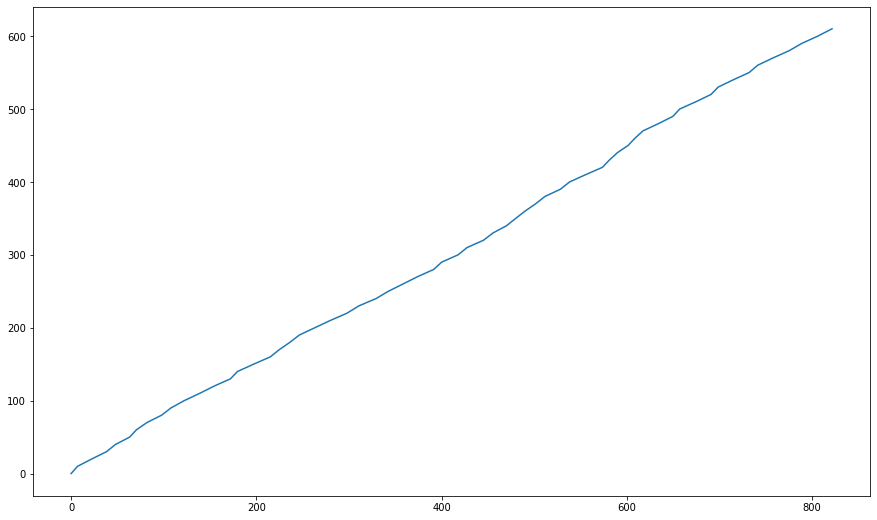

In [ ]:
import matplotlib.pyplot as plt 

x = [0]
y = [0]
plt_1 = plt.figure(figsize=(15, 9))
for i in range(len(final[0][1])):
  x.append(final_with_time[0][1][i][1])
  y.append((i+1)*10)
plt.plot(x, y)
plt.show()

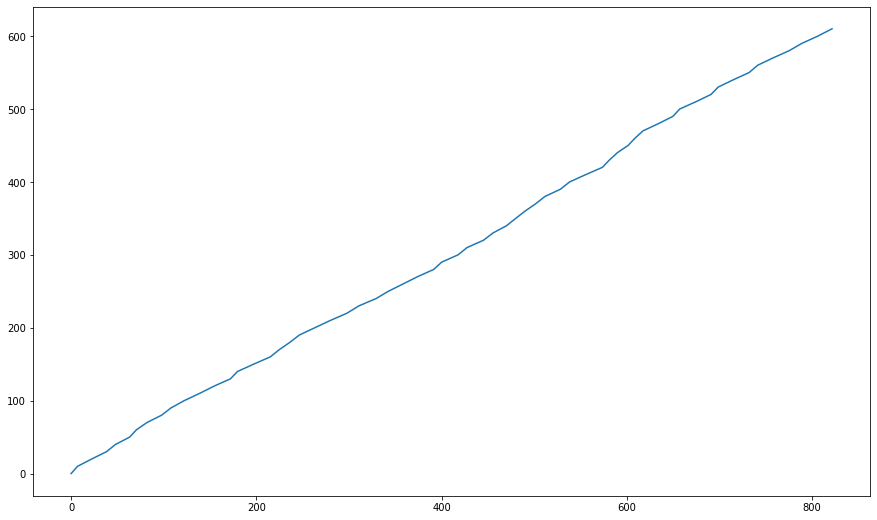

In [ ]:
import matplotlib.pyplot as plt 

x = [0]
y = [0]
plt_1 = plt.figure(figsize=(15, 9))
for i in range(len(final[0][1])):
  x.append(final_with_time[0][1][i][1])
  y.append((i+1)*10)
plt.plot(x, y)
plt.show()